# Plot for Summary Report: Herd Milk Production by Month

In [3]:
%run 'helpers-for-report-plot-generation.ipynb'

In [7]:
def get_data():
    return get_dataset('milk_volume')

def build_daily_totals_dataframe(milk):
    """Build empty dataframe with 'date' series: dataframe"""
    max_date = milk.index.max()
    min_date = milk.index.min()
    day_totals = pd.DataFrame()
    day_totals['date'] = pd.date_range(start=min_date, end=max_date)
    day_totals['milk_weight'] = np.NaN
    return day_totals.set_index('date')

def get_milk_sum_for_date(milk, date, replacement_value):
    """Returns the total volume of milk for a single day: float"""
    milk = milk.reset_index()
    date_mask = milk['date'] == date
    daily_sum = milk[date_mask]['milk_weight'].sum()
    
    # Daily sums under 10,000 milk-pounds are assumed invalid
    # Validated by 
    if daily_sum < 10000:
        daily_sum = np.NaN
    return daily_sum

def calculate_daily_totals(milk):
    daily_mean = milk.groupby('date')['milk_weight'].sum().mean()
    milk = milk.set_index('date').sort_index()
    data = build_daily_totals_dataframe(milk)
    for index_date, row in data.iterrows():
        data.loc[index_date]['milk_weight'] = get_milk_sum_for_date(milk, index_date, daily_mean)
    return data.fillna(method='backfill')

def get_total_gallons_of_milk(daily_totals):
    daily_totals['gallons'] = daily_totals['milk_weight'] / 8.6
    daily_totals = daily_totals['2016-01-01':'2017-12-31']
    milk_2016 = daily_totals['2016-01-01':'2016-12-31']
    milk_2017 = daily_totals['2017-01-01':'2017-12-31']
    print('Total Number of Gallons Produced In 2016 and 2017: ', daily_totals.sum()['gallons'])
    print('Total Number of Gallons Produced 2016: ', milk_2016.sum()['gallons'])
    print('Total Number of Gallons Produced 2017: ', milk_2017.sum()['gallons'])
    print('Total Milk-Weight Produced In 2016 and 2017: ', daily_totals.sum()['milk_weight'])
    print('Total Milk-Weight Produced 2016: ', milk_2016.sum()['milk_weight'])
    print('Total Milk-Weight Produced 2017: ', milk_2017.sum()['milk_weight'])

milk = get_data()
print('Mean Daily Milk Weight Produced: ', milk.groupby('date')['milk_weight'].sum().mean())
daily_totals = calculate_daily_totals(milk)
get_total_gallons_of_milk(daily_totals)

Mean Daily Milk Weight Produced:  11030.785746352401
Total Number of Gallons Produced In 2016 and 2017:  959884.186047
Total Number of Gallons Produced 2016:  474114.651163
Total Number of Gallons Produced 2017:  485769.534884
Total Milk-Weight Produced In 2016 and 2017:  8255004.0
Total Milk-Weight Produced 2016:  4077386.0
Total Milk-Weight Produced 2017:  4177618.0


In [8]:
def plot_total_milk_by_month(milk, start='2016-01-01', end='2017-12-31'):
    milk = milk[start:end].resample('M').sum()['milk_weight'].reset_index()
    
    milk['formated_date'] = milk['date'].dt.strftime('%b %Y')
    
    minimum = milk['milk_weight'].min()
    maximum = milk['milk_weight'].max()
    
    fig, ax = plt.subplots(figsize=(15, 5))
    ax = sns.pointplot(ax=ax, x='formated_date', y='milk_weight', data=milk)
    weight_min = ax.axhline(minimum, ls='--', c='red')
    weight_max = ax.axhline(maximum, ls='--', c='green')
    _ = plt.ylabel('Total Milk-Weight (lb)', size=12)
    _ = plt.xlabel('Month', size=12)
    _ = plt.xticks(rotation='65')
    _ = plt.title(f'Monthly Milk Totals, 2016-2017', size=16)
    _ = plt.legend([weight_min, weight_max], 
                   [f'Min: {int(minimum)} milk-pounds', f'Max: {int(maximum)} milk-pounds'], 
                   loc='best')
     
    save_plot_for_summary_report('/herd-total-milk-by-month.png')
    return ax

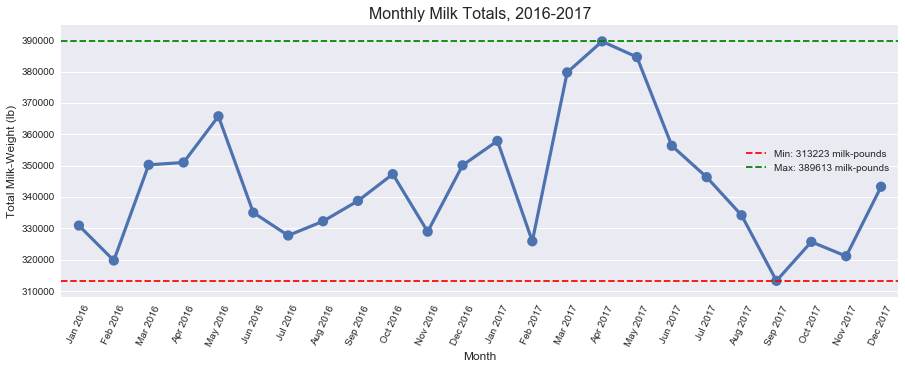

In [6]:
plot_total_milk_by_month(daily_totals, start='2016-01-01', end='2017-12-31')
plt.show()